In [ ]:
#Importing Libraries

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms


# Data Downloading

In [ ]:
#Mount drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -P "/content/drive/MyDrive/Colab Notebooks/Dataset/" https://raw.githubusercontent.com/arj7192/MasteringPyTorchV2/refs/heads/main/Chapter02/imagenet1000_clsidx_to_labels.txt

--2025-04-25 13:00:13--  https://raw.githubusercontent.com/arj7192/MasteringPyTorchV2/refs/heads/main/Chapter02/imagenet1000_clsidx_to_labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/Dataset/imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.007s  

2025-04-25 13:00:13 (4.12 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/Dataset/imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



# Data Loader

In [ ]:
from typing_extensions import dataclass_transform
# Local data directory path
ddir = "/content/drive/MyDrive/Colab Notebooks/Dataset/hymenoptera_data/"

# Data normalization and augmentation transformations
# for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the
# mean of all pixel values for all images in the training
# set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     [0.490, 0.449, 0.411],
                                     [0.231,0.221,0.230])]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   [0.490, 0.449, 0.411],
                                   [0.231,0.221,0.230])])}

img_data = {k:datasets.ImageFolder(os.path.join(ddir,k), data_transformers[k])
            for k in ['train','val']}

dloaders = {k:torch.utils.data.DataLoader(img_data[k],
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=2)
            for k in ['train','val']}
dset_sizes = {k:len(img_data[k]) for k in ['train','val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import ast

with open("/content/drive/MyDrive/Colab Notebooks/Dataset/" + "imagenet1000_clsidx_to_labels.txt", "r") as f:
    classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k:classes_dict[k] for k in list(classes_dict.keys())[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


# Image Visualization

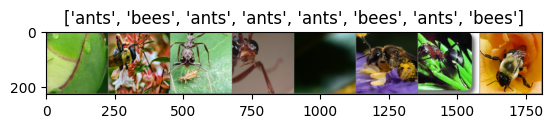

In [ ]:
def imageshow(img, text=None):
  """
    img.numpy() -> Converts if image in PyTorch tensor then it get converted into a NumPy ndarray (a multi-dimensional array object in NumPy).
    .transpose((1,2,0)) -> This method rearranges the dimensions (axes) of the NumPy array. In the context of image data, tensors or arrays
    often have a channel-first format (C, H, W), where C represents the color channels (e.g., Red, Green, Blue), H is the height of the image,
    and W is the width. Libraries like Matplotlib, which is used for plotting, typically expect the channel dimension to be the last one (H, W, C).
    This transpose((1, 2, 0)) operation reorders the dimensions so that the channel dimension moves from the first position (index 0)
    to the last position (index 2).
    Why is this required?
    This step is necessary to convert the image data into a format that Matplotlib's imshow function can correctly interpret and display as an image.
  """
  img = img.numpy().transpose((1,2,0))
  """
  avg = np.array([0.490, 0.449, 0.411]): This line creates a NumPy array named avg containing three floating-point numbers.
  These values typically represent the mean values used for normalization when the image data was initially processed
  (e.g., when training a neural network). The order usually corresponds to the Red, Green, and Blue channels, respectively.

  stddev = np.array([0.231,0.221,0.230]): Similarly, this line creates a NumPy array named stddev containing three floating-point numbers.
  These values usually represent the standard deviation values used for normalization, again corresponding to the Red, Green, and Blue channels.

  Why is this required?
  When image data is prepared for training deep learning models, it's often normalized by subtracting the mean and dividing by the standard deviation
  for each color channel. This helps in stabilizing the training process. To display the original image, we need to reverse this normalization process.
  The avg and stddev arrays hold the values used for this original normalization.
  """
  avg = np.array([0.490, 0.449, 0.411])
  stddev = np.array([0.231,0.221,0.230])
  """
  img = stddev * img + avg: This line performs the inverse of the normalization process.

  stddev * img -> This multiplies each pixel value in each channel of the img array by the corresponding standard deviation value.
  NumPy's broadcasting rules allow this element-wise multiplication.
  + avg -> This then adds the corresponding mean value to each pixel value in each channel.

  Why is this required?
  As mentioned earlier, this step reverses the normalization that was likely applied to the image data. Without this step, the pixel values might be in a
  range that doesn't correspond to standard image intensity values (e.g., 0-255 or 0-1), and the image would not be displayed correctly.
  """
  img = stddev * img + avg
  """
  img = np.clip(img, 0, 1) -> This line ensures that all pixel values in the img array are within the valid range of 0 to 1.
  After the denormalization, some values might fall outside this range due to floating-point inaccuracies or the original normalization process.
  Clipping them to the [0, 1] range is important for correct image display, as many image display functions expect pixel values in this normalized range.

  Why is this required?
  This step handles potential out-of-range pixel values after the denormalization, ensuring that the imshow function receives data in a format it can
  handle to produce a meaningful image.
  """
  img = np.clip(img, 0, 1)
  """
  plt.imshow(img): This line uses the imshow function from the Matplotlib library (plt is a common alias for matplotlib.pyplot) to display the image
  represented by the img NumPy array. Matplotlib interprets the array as image data and renders it.

  Why is this required?
  This is the core step that actually visualizes the processed image data.
  """
  plt.imshow(img)
  if text is not None:
    plt.title(text)

# Generate one train dataset batch
images, labels = next(iter(dloaders['train']))
# Generate a grid from batch
grid = torchvision.utils.make_grid(images)
imageshow(grid, text=[classes[x] for x in labels])

# Visualizing Prediction Routine

In [ ]:
def visualize_predictions(pretrained_model,max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops,1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2,2,imgs_counter)
                ax.axis('off')
                ax.set_title(f'Prediction: {classes_dict[int(preds[j])]}')
                imageshow(imgs.cpu().data[j])


                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

# Inference

In [ ]:
model = models.vgg13(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:05<00:00, 90.8MB/s]


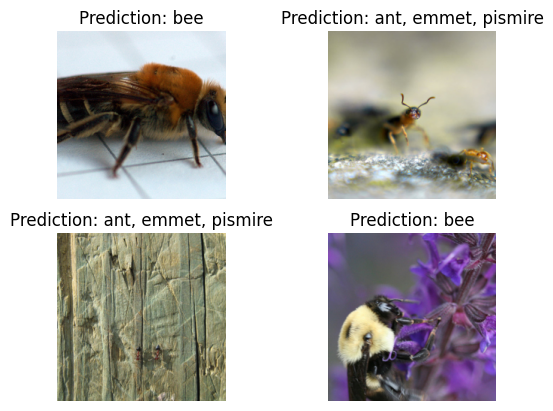

In [ ]:
visualize_predictions(model)